### Mutual Information at Decompactification Limit

We choose the same parameter range as the decompactification limit example.

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Mutual_Info_decom.csv', encoding='utf-8', encoding_errors='ignore')
df


,Correct Entropy,Approx Entropy,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,1.166100,1.164152,0.686130,0.235537,0.107905,0.055683,0.030705,0.017681,0.010508,0.006406,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
1,1.165850,1.163903,0.686052,0.235484,0.107868,0.055658,0.030688,0.017669,0.010500,0.006401,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
2,1.165600,1.163653,0.685973,0.235430,0.107831,0.055633,0.030670,0.017657,0.010492,0.006395,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
3,1.165350,1.163404,0.685895,0.235376,0.107795,0.055608,0.030653,0.017645,0.010484,0.006390,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
4,1.165100,1.163155,0.685816,0.235322,0.107758,0.055582,0.030636,0.017633,0.010476,0.006384,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.270427,0.269424,0.231339,0.027659,0.004958,0.001366,0.000636,0.000424,0.000328,0.000269,...,0.000022,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016,0.000016
9996,0.270386,0.269382,0.231307,0.027652,0.004956,0.001366,0.000636,0.000424,0.000328,0.000269,...,0.000022,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016,0.000016
9997,0.270344,0.269341,0.231275,0.027645,0.004954,0.001365,0.000636,0.000423,0.000328,0.000269,...,0.000022,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016,0.000016
9998,0.270302,0.269299,0.231243,0.027637,0.004953,0.001365,0.000635,0.000423,0.000328,0.000269,...,0.000022,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016,0.000016


C:\Users\Chih-Hung Wu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


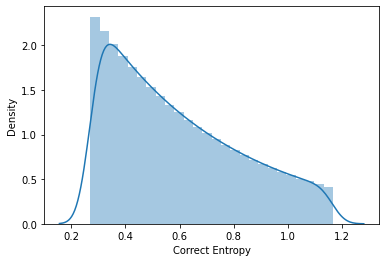

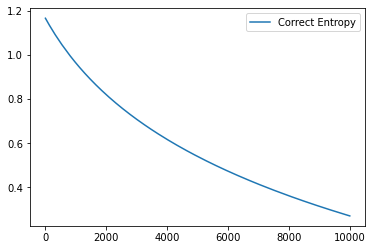

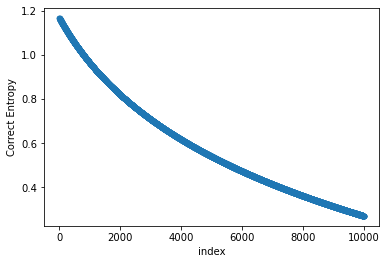

In [5]:
# Here we should check the data
# If there are problems with data (e.g. extreme values, weired distribution), use Scaler in the next block

print(sns.distplot(df['Correct Entropy']))
# Safe to ignore warnings

print(df.plot(y='Correct Entropy', use_index=True))

print(df.reset_index().plot.scatter(x='index',y='Correct Entropy'))

In [6]:
df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)

# do the splitting twice for to separate the data points to train-validation-test sets, we do 80-10-10%.

X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 
# 1.0/9 x 0.9 = 0.1

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    # sample hyperparameter values from hp object. After sampling, these values (such as "units" variables here) 
    # are just regular Python constants.
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    # different kinds of hyperparameters are available: Int, Float, Boolean, Choice, Fixed
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 
    # the function returns a compiled model
    
# note we can also use hp.xxx to tune layers, activation functions etc.

tuner = kt.BayesianOptimization(build_model, # specify the model-building fun (or hypermodel instance)
                                objective="val_loss", 
                                # specify the metric that the tuner will seek to optimize, always specify validation metrics,
                                # since the goal of the search process is to find models that generalize
                                max_trials=10, # max number of different model configurations ("trials")
                                executions_per_trial=2, 
                                # To reduce metrics variance, you can train the same model multiple times and 
                                # average the results. This is how many training rounds (executions) to run for each trial. 
                                directory="MutualInfoDecomTest", # where to store search logs
                                overwrite=True, 
                                #whether to overwrite data in directory to start a new search. 
                                # Set this to True if you have modified the model-building fun, or to False to resume 
                                # a previously started search with the same model-building fun.
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 
# patience=x: interrupts training when monitor has stopped improving for x epochs

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)
# this takes the same arguments as fit() (it simply passes them down to fit() for each new model)

# here use a large number of epochs (you don't know in advance how many epochs each model will need), and use an EarlyStopping
# callback to stop training when you start overfitting.

# print(tuner.search_space_summary())

Trial 10 Complete [00h 00m 12s]
val_loss: 1.0769974778668256e-06

Best val_loss So Far: 8.053494013893214e-07
Total elapsed time: 00h 01m 57s
INFO:tensorflow:Oracle triggered exit


In [7]:
# query the best hyperparameter configurations, can then be used to retrain
# we can then pass to the model-building function

top_n = 4 # query the best 4
best_hps = tuner.get_best_hyperparameters(top_n) 
best_hps # returns a list

In [8]:
# Build the model with the best hp and retrain the model by itself "with the entire dataset"
# We will need to increase slightly the epochs as we are training on the entire dataset.

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

Epoch 1/60
282/282 [==============================] - 1s 1ms/step - loss: 0.0828 - mae: 0.2069
Epoch 2/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0097 - mae: 0.0837
Epoch 3/60
282/282 [==============================] - 0s 1ms/step - loss: 0.0029 - mae: 0.0451
Epoch 4/60
282/282 [==============================] - 0s 1ms/step - loss: 3.7136e-04 - mae: 0.0155
Epoch 5/60
282/282 [==============================] - 0s 1ms/step - loss: 2.9389e-05 - mae: 0.0043
Epoch 6/60
282/282 [==============================] - 0s 1ms/step - loss: 1.2474e-05 - mae: 0.0030
Epoch 7/60
282/282 [==============================] - 0s 1ms/step - loss: 1.0761e-05 - mae: 0.0028
Epoch 8/60
282/282 [==============================] - 0s 1ms/step - loss: 9.3833e-06 - mae: 0.0026
Epoch 9/60
282/282 [==============================] - 0s 1ms/step - loss: 8.0215e-06 - mae: 0.0024
Epoch 10/60
282/282 [==============================] - 0s 1ms/step - loss: 6.6915e-06 - mae: 0.0022
Epoch 11/60
282/282 [

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                1632      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


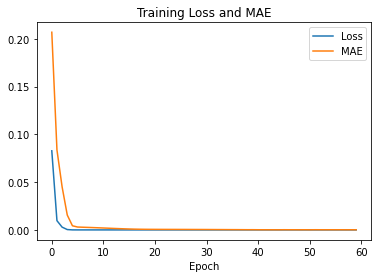

     Correct Entropy  Model Predictions
0           0.457445           0.456459
1           0.562814           0.561842
2           0.854334           0.853100
3           0.558494           0.557522
4           0.575158           0.574185
..               ...                ...
995         0.623420           0.622432
996         0.431874           0.430887
997         0.688920           0.687887
998         0.826955           0.825756
999         0.375940           0.374977

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


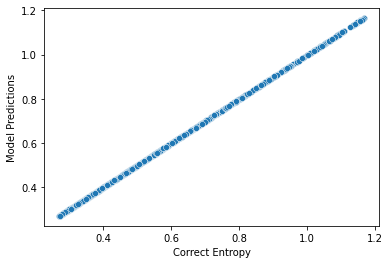

In [10]:
plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# note that we don't need to plot the val_loss as we are training on the full dataset except test data

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

In [11]:
# compute percent relative error (=(|absolute error|/true value)*100%)

# extract the X_test and then sum each row to get the approximate entropy
df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


# absolute error for model predictions and approximate entropy

df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

# percent relative error for model predictions and approximate entropy

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

     Correct Entropy  Model Predictions  Approximate Entropy
0           0.457445           0.456459             0.456286
1           0.562814           0.561842             0.561560
2           0.854334           0.853100             0.852778
3           0.558494           0.557522             0.557244
4           0.575158           0.574185             0.573893
..               ...                ...                  ...
995         0.623420           0.622432             0.622107
996         0.431874           0.430887             0.430738
997         0.688920           0.687887             0.687542
998         0.826955           0.825756             0.825429
999         0.375940           0.374977             0.374851

[1000 rows x 3 columns]
     Abs Error for Model  Abs Error for Approx
0               0.000986              0.001159
1               0.000972              0.001254
2               0.001234              0.001556
3               0.000972              0.001250
4       

In [12]:
best_models = tuner.get_best_models(top_n)
best_models

In [13]:
model = best_models[2] 
model.fit(X_train_full, y_train_full, epochs=10)

Epoch 1/10
282/282 [==============================] - 1s 1ms/step - loss: 5.5827e-07 - mae: 5.9945e-04
Epoch 2/10
282/282 [==============================] - 0s 1ms/step - loss: 4.3069e-07 - mae: 5.2210e-04
Epoch 3/10
282/282 [==============================] - 0s 1ms/step - loss: 3.2208e-07 - mae: 4.4626e-04
Epoch 4/10
282/282 [==============================] - 0s 1ms/step - loss: 2.3140e-07 - mae: 3.7510e-04
Epoch 5/10
282/282 [==============================] - 0s 1ms/step - loss: 1.6298e-07 - mae: 3.1192e-04
Epoch 6/10
282/282 [==============================] - 0s 1ms/step - loss: 1.1425e-07 - mae: 2.5404e-04
Epoch 7/10
282/282 [==============================] - 0s 1ms/step - loss: 8.0152e-08 - mae: 2.1604e-04
Epoch 8/10
282/282 [==============================] - 0s 1ms/step - loss: 5.8671e-08 - mae: 1.9156e-04
Epoch 9/10
282/282 [==============================] - 0s 1ms/step - loss: 4.6409e-08 - mae: 1.7688e-04
Epoch 10/10
282/282 [==============================] - 0s 1ms/step - loss

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


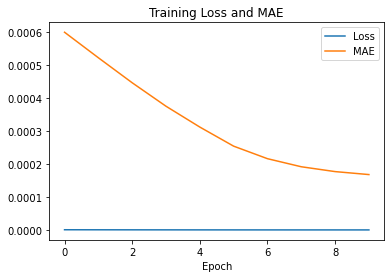

     Correct Entropy  Model Predictions
0           0.457445           0.457672
1           0.562814           0.562929
2           0.854334           0.854102
3           0.558494           0.558616
4           0.575158           0.575251
..               ...                ...
995         0.623420           0.623419
996         0.431874           0.432095
997         0.688920           0.688798
998         0.826955           0.826712
999         0.375940           0.376081

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


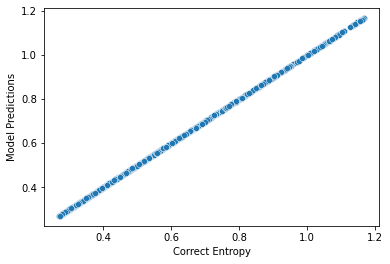

In [15]:
plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# note that we don't need to plot the val_loss as we are training on the full dataset except test data

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

In [16]:
# compute percent relative error (=(|absolute error|/true value)*100%)

# extract the X_test and then sum each row to get the approximate entropy
df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


# absolute error for model predictions and approximate entropy

df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

# percent relative error for model predictions and approximate entropy

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

     Correct Entropy  Model Predictions  Approximate Entropy
0           0.457445           0.457672             0.456286
1           0.562814           0.562929             0.561560
2           0.854334           0.854102             0.852778
3           0.558494           0.558616             0.557244
4           0.575158           0.575251             0.573893
..               ...                ...                  ...
995         0.623420           0.623419             0.622107
996         0.431874           0.432095             0.430738
997         0.688920           0.688798             0.687542
998         0.826955           0.826712             0.825429
999         0.375940           0.376081             0.374851

[1000 rows x 3 columns]
     Abs Error for Model  Abs Error for Approx
0           2.269999e-04              0.001159
1           1.147362e-04              0.001254
2           2.323421e-04              0.001556
3           1.221613e-04              0.001250
4       

### Reduce the dimensions of data (keep only k=10).

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Mutual_Info_decom.csv', encoding='utf-8', encoding_errors='ignore')

df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)

df2 = df1.iloc[range(0,10000),range(0,10)]
df2

# note that in the end we need to re-compute the approximate entropy by summing each row

,1,2,3,4,5,6,7,8,9,10
0,0.686130,0.235537,0.107905,0.055683,0.030705,0.017681,0.010508,0.006406,0.003994,0.002544
1,0.686052,0.235484,0.107868,0.055658,0.030688,0.017669,0.010500,0.006401,0.003990,0.002541
2,0.685973,0.235430,0.107831,0.055633,0.030670,0.017657,0.010492,0.006395,0.003986,0.002539
3,0.685895,0.235376,0.107795,0.055608,0.030653,0.017645,0.010484,0.006390,0.003982,0.002536
4,0.685816,0.235322,0.107758,0.055582,0.030636,0.017633,0.010476,0.006384,0.003979,0.002533
...,...,...,...,...,...,...,...,...,...,...
9995,0.231339,0.027659,0.004958,0.001366,0.000636,0.000424,0.000328,0.000269,0.000227,0.000195
9996,0.231307,0.027652,0.004956,0.001366,0.000636,0.000424,0.000328,0.000269,0.000227,0.000195
9997,0.231275,0.027645,0.004954,0.001365,0.000636,0.000423,0.000328,0.000269,0.000227,0.000195
9998,0.231243,0.027637,0.004953,0.001365,0.000635,0.000423,0.000328,0.000269,0.000227,0.000195


In [3]:
X = df2
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, random_state=42) 
# 1.0/9 x 0.9 = 0.1

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    # sample hyperparameter values from hp object. After sampling, these values (such as "units" variables here) 
    # are just regular Python constants.
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    # different kinds of hyperparameters are available: Int, Float, Boolean, Choice, Fixed
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 
    # the function returns a compiled model
    
# note we can also use hp.xxx to tune layers, activation functions etc.

tuner = kt.BayesianOptimization(build_model, # specify the model-building fun (or hypermodel instance)
                                objective="val_loss", 
                                # specify the metric that the tuner will seek to optimize, always specify validation metrics,
                                # since the goal of the search process is to find models that generalize
                                max_trials=10, # max number of different model configurations ("trials")
                                executions_per_trial=2, 
                                # To reduce metrics variance, you can train the same model multiple times and 
                                # average the results. This is how many training rounds (executions) to run for each trial. 
                                directory="MutualInfoDecomTest", # where to store search logs
                                overwrite=True, 
                                #whether to overwrite data in directory to start a new search. 
                                # Set this to True if you have modified the model-building fun, or to False to resume 
                                # a previously started search with the same model-building fun.
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 
# patience=x: interrupts training when monitor has stopped improving for x epochs

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)
# this takes the same arguments as fit() (it simply passes them down to fit() for each new model)

# here use a large number of epochs (you don't know in advance how many epochs each model will need), and use an EarlyStopping
# callback to stop training when you start overfitting.

# print(tuner.search_space_summary())

Trial 10 Complete [00h 00m 12s]
val_loss: 5.236102538219711e-06

Best val_loss So Far: 5.1982933957361865e-08
Total elapsed time: 00h 01m 46s
INFO:tensorflow:Oracle triggered exit


In [4]:
# query the best hyperparameter configurations, can then be used to retrain
# we can then pass to the model-building function

top_n = 4 # query the best 4
best_hps = tuner.get_best_hyperparameters(top_n) 
best_hps # returns a list

In [5]:
# Build the model with the best hp and retrain the model by itself "with the entire dataset"
# We will need to increase slightly the epochs as we are training on the entire dataset.

model = build_model(best_hps[0])
model.fit(X_train_full, y_train_full, epochs=60)

Epoch 1/60
282/282 [==============================] - 1s 988us/step - loss: 0.0254 - mae: 0.1057
Epoch 2/60
282/282 [==============================] - 0s 994us/step - loss: 8.7008e-04 - mae: 0.0222
Epoch 3/60
282/282 [==============================] - 0s 983us/step - loss: 1.2463e-05 - mae: 0.0025
Epoch 4/60
282/282 [==============================] - 0s 980us/step - loss: 3.4860e-06 - mae: 0.0015
Epoch 5/60
282/282 [==============================] - 0s 976us/step - loss: 2.2612e-06 - mae: 0.0012
Epoch 6/60
282/282 [==============================] - 0s 959us/step - loss: 1.6434e-06 - mae: 0.0011
Epoch 7/60
282/282 [==============================] - 0s 1ms/step - loss: 1.2494e-06 - mae: 9.5251e-04
Epoch 8/60
282/282 [==============================] - 0s 1ms/step - loss: 8.3987e-07 - mae: 7.8367e-04
Epoch 9/60
282/282 [==============================] - 0s 1ms/step - loss: 4.7802e-07 - mae: 5.6721e-04
Epoch 10/60
282/282 [==============================] - 0s 1ms/step - loss: 2.7424e-07 - m

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                704       
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


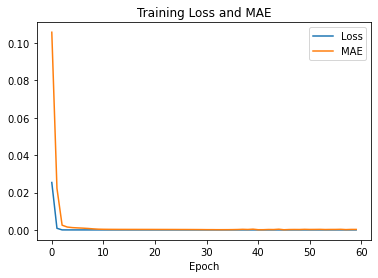

     Correct Entropy  Model Predictions
0           0.457445           0.457298
1           0.562814           0.562789
2           0.854334           0.854199
3           0.558494           0.558465
4           0.575158           0.575141
..               ...                ...
995         0.623420           0.623408
996         0.431874           0.431814
997         0.688920           0.688873
998         0.826955           0.826823
999         0.375940           0.375968

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


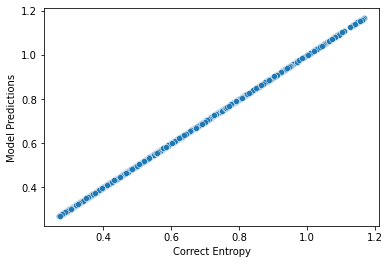

In [7]:
plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# note that we don't need to plot the val_loss as we are training on the full dataset except test data

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

In [8]:
# compute percent relative error (=(|absolute error|/true value)*100%)

# extract the X_test and then sum each row to get the approximate entropy
df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


# absolute error for model predictions and approximate entropy

df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

# percent relative error for model predictions and approximate entropy

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

     Correct Entropy  Model Predictions  Approximate Entropy
0           0.457445           0.457298             0.454035
1           0.562814           0.562789             0.559165
2           0.854334           0.854199             0.849617
3           0.558494           0.558465             0.554856
4           0.575158           0.575141             0.571480
..               ...                ...                  ...
995         0.623420           0.623408             0.619617
996         0.431874           0.431814             0.428519
997         0.688920           0.688873             0.684927
998         0.826955           0.826823             0.822395
999         0.375940           0.375968             0.372702

[1000 rows x 3 columns]
     Abs Error for Model  Abs Error for Approx
0               0.000147              0.003410
1               0.000025              0.003649
2               0.000135              0.004717
3               0.000029              0.003638
4       

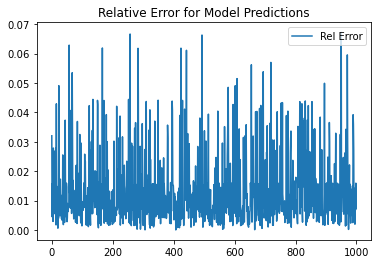

In [9]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Testing predictions outside the training range

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Mutual_Info_decom.csv', encoding='utf-8', encoding_errors='ignore')

df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)

# do the splitting twice for to separate the data points to train-validation-test sets, we do 80-10-10%.

X = df1
y = df['Correct Entropy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9, shuffle=False) 
# 1.0/9 x 0.9 = 0.1

In [3]:
def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    # sample hyperparameter values from hp object. After sampling, these values (such as "units" variables here) 
    # are just regular Python constants.
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    # different kinds of hyperparameters are available: Int, Float, Boolean, Choice, Fixed
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 
    # the function returns a compiled model
    
# note we can also use hp.xxx to tune layers, activation functions etc.

tuner = kt.BayesianOptimization(build_model, # specify the model-building fun (or hypermodel instance)
                                objective="val_loss", 
                                # specify the metric that the tuner will seek to optimize, always specify validation metrics,
                                # since the goal of the search process is to find models that generalize
                                max_trials=10, # max number of different model configurations ("trials")
                                executions_per_trial=2, 
                                # To reduce metrics variance, you can train the same model multiple times and 
                                # average the results. This is how many training rounds (executions) to run for each trial. 
                                directory="MutualInfoDecomTest", # where to store search logs
                                overwrite=True, 
                                #whether to overwrite data in directory to start a new search. 
                                # Set this to True if you have modified the model-building fun, or to False to resume 
                                # a previously started search with the same model-building fun.
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 
# patience=x: interrupts training when monitor has stopped improving for x epochs

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)
# this takes the same arguments as fit() (it simply passes them down to fit() for each new model)

# here use a large number of epochs (you don't know in advance how many epochs each model will need), and use an EarlyStopping
# callback to stop training when you start overfitting.

# print(tuner.search_space_summary())

Trial 10 Complete [00h 00m 03s]
val_loss: 1.7510040422052953e-06

Best val_loss So Far: 3.2209694467155714e-07
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


In [4]:
top_n = 4
best_models = tuner.get_best_models(top_n)
best_models

In [5]:
model = best_models[2] 
model.fit(X_train_full, y_train_full, epochs=10)

Epoch 1/10
282/282 [==============================] - 1s 972us/step - loss: 2.0826e-05 - mae: 0.0039
Epoch 2/10
282/282 [==============================] - 0s 970us/step - loss: 1.8238e-05 - mae: 0.0039
Epoch 3/10
282/282 [==============================] - 0s 951us/step - loss: 1.7778e-05 - mae: 0.0039
Epoch 4/10
282/282 [==============================] - 0s 1ms/step - loss: 1.7466e-05 - mae: 0.0039
Epoch 5/10
282/282 [==============================] - 0s 1ms/step - loss: 1.7770e-05 - mae: 0.0040
Epoch 6/10
282/282 [==============================] - 0s 976us/step - loss: 1.7086e-05 - mae: 0.0039
Epoch 7/10
282/282 [==============================] - 0s 976us/step - loss: 1.7511e-05 - mae: 0.0039
Epoch 8/10
282/282 [==============================] - 0s 948us/step - loss: 1.7372e-05 - mae: 0.0039
Epoch 9/10
282/282 [==============================] - 0s 969us/step - loss: 1.7347e-05 - mae: 0.0039
Epoch 10/10
282/282 [==============================] - 0s 930us/step - loss: 1.7334e-05 - mae: 

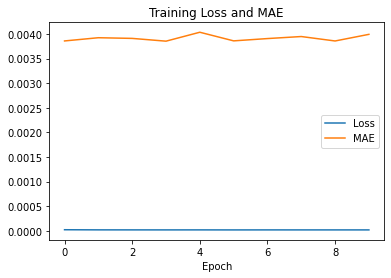

     Correct Entropy  Model Predictions
0           0.313725           0.315521
1           0.313679           0.315475
2           0.313634           0.315430
3           0.313588           0.315385
4           0.313543           0.315339
..               ...                ...
995         0.270427           0.272303
996         0.270386           0.272261
997         0.270344           0.272220
998         0.270302           0.272178
999         0.270261           0.272137

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


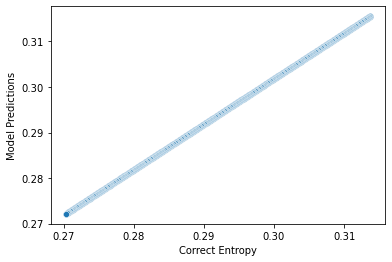

In [6]:
plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# note that we don't need to plot the val_loss as we are training on the full dataset except test data

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

In [7]:
# compute percent relative error (=(|absolute error|/true value)*100%)

# extract the X_test and then sum each row to get the approximate entropy
df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


# absolute error for model predictions and approximate entropy

df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

# percent relative error for model predictions and approximate entropy

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

     Correct Entropy  Model Predictions  Approximate Entropy
0           0.313725           0.315521             0.312687
1           0.313679           0.315475             0.312642
2           0.313634           0.315430             0.312596
3           0.313588           0.315385             0.312551
4           0.313543           0.315339             0.312506
..               ...                ...                  ...
995         0.270427           0.272303             0.269424
996         0.270386           0.272261             0.269382
997         0.270344           0.272220             0.269341
998         0.270302           0.272178             0.269299
999         0.270261           0.272137             0.269257

[1000 rows x 3 columns]
     Abs Error for Model  Abs Error for Approx
0               0.001796              0.001038
1               0.001796              0.001037
2               0.001796              0.001038
3               0.001797              0.001037
4       

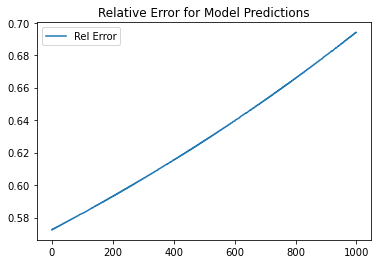

In [8]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### Testing predictions outside the training range (but split data with interval)

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") 
# to restart the kernel, prevent from reusing any trained models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

df = pd.read_csv('Mutual_Info_decom.csv', encoding='utf-8', encoding_errors='ignore')

df1 = df.drop(['Correct Entropy','Approx Entropy'], axis = 1)

# do the splitting twice for to separate the data points to train-validation-test sets, we do 80-10-10%.

X = df1
y = df['Correct Entropy']

X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.1, shuffle=False) 
X1 = X_train1.iloc[range(0,5000)]
X2 = X_train1.iloc[range(5500, 8000)]
X3 = X_train1.iloc[range(8500, 9000)]
X_train = pd.concat([X1, X2, X3], axis=0)

X4 = y_train1.iloc[range(0,5000)]
X5 = y_train1.iloc[range(5500, 8000)]
X6 = y_train1.iloc[range(8500, 9000)]
y_train = pd.concat([X4, X5, X6], axis=0)

y1 = X_train1.iloc[range(5000, 5500)]
y2 = X_train1.iloc[range(8000, 8500)]
X_test = pd.concat([y1, y2], axis=0)

y3 = y_train1.iloc[range(5000, 5500)]
y4 = y_train1.iloc[range(8000, 8500)]
y_test = pd.concat([y3, y4], axis=0)

In [2]:
X_train

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.686130,0.235537,0.107905,0.055683,0.030705,0.017681,0.010508,0.006406,0.003994,0.002544,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
1,0.686052,0.235484,0.107868,0.055658,0.030688,0.017669,0.010500,0.006401,0.003990,0.002541,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
2,0.685973,0.235430,0.107831,0.055633,0.030670,0.017657,0.010492,0.006395,0.003986,0.002539,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
3,0.685895,0.235376,0.107795,0.055608,0.030653,0.017645,0.010484,0.006390,0.003982,0.002536,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
4,0.685816,0.235322,0.107758,0.055582,0.030636,0.017633,0.010476,0.006384,0.003979,0.002533,...,0.000037,0.000036,0.000035,0.000033,0.000032,0.000031,0.000030,0.000029,0.000028,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.264077,0.035694,0.006938,0.001860,0.000763,0.000460,0.000341,0.000276,0.000232,0.000199,...,0.000022,0.000021,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016
8996,0.264043,0.035685,0.006936,0.001859,0.000763,0.000460,0.000341,0.000276,0.000232,0.000199,...,0.000022,0.000021,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016
8997,0.264010,0.035676,0.006933,0.001858,0.000763,0.000460,0.000341,0.000276,0.000232,0.000199,...,0.000022,0.000021,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016
8998,0.263976,0.035668,0.006931,0.001858,0.000762,0.000460,0.000341,0.000276,0.000232,0.000199,...,0.000022,0.000021,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000017,0.000016


In [3]:
y_train

0       1.166100
1       1.165850
2       1.165600
3       1.165350
4       1.165100
          ...   
8995    0.313952
8996    0.313907
8997    0.313861
8998    0.313816
8999    0.313770
Name: Correct Entropy, Length: 8000, dtype: float64

In [4]:
X_test

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
5000,0.412803,0.085729,0.024067,0.007831,0.002889,0.001239,0.000640,0.000401,0.000292,0.000234,...,0.000026,0.000025,0.000024,0.000023,0.000022,0.000021,0.000021,0.000020,0.000019,0.000019
5001,0.412761,0.085712,0.024060,0.007828,0.002888,0.001238,0.000640,0.000401,0.000292,0.000234,...,0.000026,0.000025,0.000024,0.000023,0.000022,0.000021,0.000021,0.000020,0.000019,0.000019
5002,0.412719,0.085694,0.024052,0.007825,0.002887,0.001238,0.000640,0.000401,0.000292,0.000234,...,0.000026,0.000025,0.000024,0.000023,0.000022,0.000021,0.000021,0.000020,0.000019,0.000019
5003,0.412677,0.085677,0.024045,0.007822,0.002885,0.001237,0.000640,0.000401,0.000292,0.000234,...,0.000026,0.000025,0.000024,0.000023,0.000022,0.000021,0.000021,0.000020,0.000019,0.000019
5004,0.412635,0.085660,0.024038,0.007819,0.002884,0.001237,0.000639,0.000400,0.000292,0.000234,...,0.000026,0.000025,0.000024,0.000023,0.000022,0.000021,0.000021,0.000020,0.000019,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,0.281005,0.040270,0.008178,0.002198,0.000857,0.000488,0.000351,0.000281,0.000235,0.000201,...,0.000023,0.000022,0.000021,0.000020,0.000019,0.000019,0.000018,0.000017,0.000017,0.000016
8496,0.280970,0.040260,0.008175,0.002197,0.000857,0.000488,0.000351,0.000281,0.000235,0.000201,...,0.000023,0.000022,0.000021,0.000020,0.000019,0.000019,0.000018,0.000017,0.000017,0.000016
8497,0.280936,0.040251,0.008173,0.002197,0.000857,0.000488,0.000351,0.000281,0.000235,0.000201,...,0.000023,0.000022,0.000021,0.000020,0.000019,0.000019,0.000018,0.000017,0.000017,0.000016
8498,0.280902,0.040241,0.008170,0.002196,0.000857,0.000488,0.000351,0.000281,0.000235,0.000201,...,0.000023,0.000022,0.000021,0.000020,0.000019,0.000019,0.000018,0.000017,0.000017,0.000016


In [5]:
y_test

5000    0.539717
5001    0.539646
5002    0.539574
5003    0.539503
5004    0.539432
          ...   
8495    0.337223
8496    0.337175
8497    0.337128
8498    0.337080
8499    0.337032
Name: Correct Entropy, Length: 1000, dtype: float64

In [6]:
def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    # sample hyperparameter values from hp object. After sampling, these values (such as "units" variables here) 
    # are just regular Python constants.
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    # different kinds of hyperparameters are available: Int, Float, Boolean, Choice, Fixed
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model 
    # the function returns a compiled model
    
# note we can also use hp.xxx to tune layers, activation functions etc.

tuner = kt.BayesianOptimization(build_model, # specify the model-building fun (or hypermodel instance)
                                objective="val_loss", 
                                # specify the metric that the tuner will seek to optimize, always specify validation metrics,
                                # since the goal of the search process is to find models that generalize
                                max_trials=10, # max number of different model configurations ("trials")
                                executions_per_trial=2, 
                                # To reduce metrics variance, you can train the same model multiple times and 
                                # average the results. This is how many training rounds (executions) to run for each trial. 
                                directory="MutualInfoDecomTest", # where to store search logs
                                overwrite=True, 
                                #whether to overwrite data in directory to start a new search. 
                                # Set this to True if you have modified the model-building fun, or to False to resume 
                                # a previously started search with the same model-building fun.
                                ) 

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),] 
# patience=x: interrupts training when monitor has stopped improving for x epochs

tuner.search(x = X_train, y = y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2,)
# this takes the same arguments as fit() (it simply passes them down to fit() for each new model)

# here use a large number of epochs (you don't know in advance how many epochs each model will need), and use an EarlyStopping
# callback to stop training when you start overfitting.

# print(tuner.search_space_summary())

Trial 10 Complete [00h 00m 06s]
val_loss: 2.5743051423887664e-07

Best val_loss So Far: 1.3436250867471244e-07
Total elapsed time: 00h 00m 52s
INFO:tensorflow:Oracle triggered exit


In [7]:
top_n = 4
best_models = tuner.get_best_models(top_n)
best_models

In [9]:
model = best_models[2] 
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
250/250 [==============================] - 1s 1ms/step - loss: 4.2885e-05 - mae: 0.0062
Epoch 2/10
250/250 [==============================] - 0s 917us/step - loss: 4.1815e-05 - mae: 0.0062
Epoch 3/10
250/250 [==============================] - 0s 937us/step - loss: 4.0705e-05 - mae: 0.0061
Epoch 4/10
250/250 [==============================] - 0s 985us/step - loss: 4.0808e-05 - mae: 0.0061
Epoch 5/10
250/250 [==============================] - 0s 957us/step - loss: 4.0137e-05 - mae: 0.0061
Epoch 6/10
250/250 [==============================] - 0s 981us/step - loss: 4.0242e-05 - mae: 0.0061
Epoch 7/10
250/250 [==============================] - 0s 1ms/step - loss: 3.9450e-05 - mae: 0.0060
Epoch 8/10
250/250 [==============================] - 0s 985us/step - loss: 4.0141e-05 - mae: 0.0061
Epoch 9/10
250/250 [==============================] - 0s 1ms/step - loss: 3.8905e-05 - mae: 0.0060
Epoch 10/10
250/250 [==============================] - 0s 965us/step - loss: 3.8405e-05 - mae: 0.

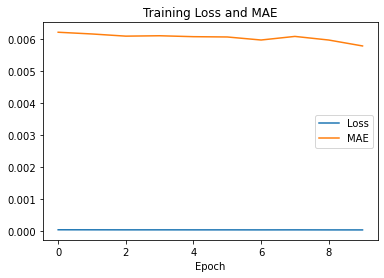

     Correct Entropy  Model Predictions
0           0.539717           0.544402
1           0.539646           0.544331
2           0.539574           0.544259
3           0.539503           0.544188
4           0.539432           0.544116
..               ...                ...
995         0.337223           0.340503
996         0.337175           0.340454
997         0.337128           0.340406
998         0.337080           0.340358
999         0.337032           0.340309

[1000 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


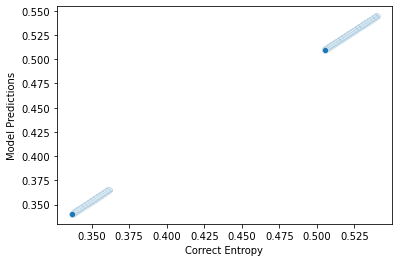

In [10]:
plt.plot(model.history.history["loss"], label="Loss")
plt.plot(model.history.history["mae"], label="MAE")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# note that we don't need to plot the val_loss as we are training on the full dataset except test data

test_predictions = model.predict(X_test)
test_pred = pd.DataFrame(test_predictions)
test_pred.columns = ['Model Predictions']

pred_df = pd.DataFrame(y_test)
pred_df_reset_index = pred_df.reset_index(drop=True)

df_compare = pd.concat([pred_df_reset_index, test_pred], axis = 1)
print(df_compare)

print(sns.scatterplot(x='Correct Entropy', y='Model Predictions', data=df_compare))

In [11]:
# compute percent relative error (=(|absolute error|/true value)*100%)

# extract the X_test and then sum each row to get the approximate entropy
df_approx = pd.DataFrame(X_test)
df_approx_reset_index = df_approx.reset_index(drop=True)
df_approx1 = df_approx_reset_index.sum(axis = 1)
df_approx1 = pd.DataFrame(df_approx1)
df_approx1.columns = ['Approximate Entropy']


df_compare1 = pd.concat([df_compare, df_approx1], axis = 1)
print(df_compare1)


# absolute error for model predictions and approximate entropy

df_abs_error1 = abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])
df_abs_error2 = abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])
df_abs_error = pd.concat([df_abs_error1, df_abs_error2], axis = 1)
df_abs_error.columns = ['Abs Error for Model', 'Abs Error for Approx']
print(df_abs_error)

# percent relative error for model predictions and approximate entropy

df_rel_error1 = (abs(df_compare1['Correct Entropy']-df_compare1['Model Predictions'])/df_compare1['Correct Entropy'])*100
df_rel_error2 = (abs(df_compare1['Correct Entropy']-df_compare1['Approximate Entropy'])/df_compare1['Correct Entropy'])*100
df_rel_error = pd.concat([df_rel_error1, df_rel_error2], axis = 1)
df_rel_error.columns = ['Rel Error for Model', 'Rel Error for Approx']
print(df_rel_error)

     Correct Entropy  Model Predictions  Approximate Entropy
0           0.539717           0.544402             0.538485
1           0.539646           0.544331             0.538413
2           0.539574           0.544259             0.538342
3           0.539503           0.544188             0.538271
4           0.539432           0.544116             0.538199
..               ...                ...                  ...
995         0.337223           0.340503             0.336166
996         0.337175           0.340454             0.336119
997         0.337128           0.340406             0.336071
998         0.337080           0.340358             0.336024
999         0.337032           0.340309             0.335976

[1000 rows x 3 columns]
     Abs Error for Model  Abs Error for Approx
0               0.004685              0.001232
1               0.004685              0.001233
2               0.004685              0.001232
3               0.004685              0.001232
4       

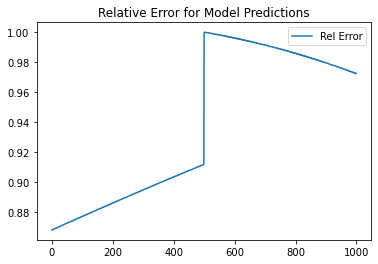

In [12]:
plt.plot(df_rel_error1, label="Rel Error")
plt.title("Relative Error for Model Predictions")
plt.legend()
plt.show()

### XXZ Spin-Chain Model